https://www.kaggle.com/pestipeti/global-wheat-detection-eda

In [ ]:
import numpy as np
import pandas as pd
import cv2
import re
from tqdm.notebook import tqdm
from PIL import Image
import hashlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

DIR_INPUT = '../Wheat'
DIR_TRAIN_IMAGES = f'{DIR_INPUT}/train'

In [ ]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df['image_id'].nunique()

In [ ]:
train_df['height'].value_counts(), train_df['width'].value_counts()

In [ ]:
def calculate_hash(im):
    md5 = hashlib.md5()
    md5.update(np.array(im).tostring())
    
    return md5.hexdigest()
    
def get_image_meta(image_id, image_src, dataset='train'):
    im = Image.open(image_src)
    extrema = im.getextrema()
    
    meta = {
        'image_id': image_id,
        'dataset': dataset,
        'hash': calculate_hash(im),
        'r_min': extrema[0][0],
        'r_max': extrema[0][1],
        'g_min': extrema[1][0],
        'g_max': extrema[1][1],
        'b_min': extrema[2][0],
        'b_max': extrema[2][1],
        'height': im.size[0],
        'width': im.size[1],
        'format': im.format,
        'mode': im.mode
    }
    return meta

In [ ]:
data = []

for i, image_id in enumerate(tqdm(train_df['image_id'].unique(), total=train_df['image_id'].unique().shape[0])):
    data.append(get_image_meta(image_id, DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_id)))

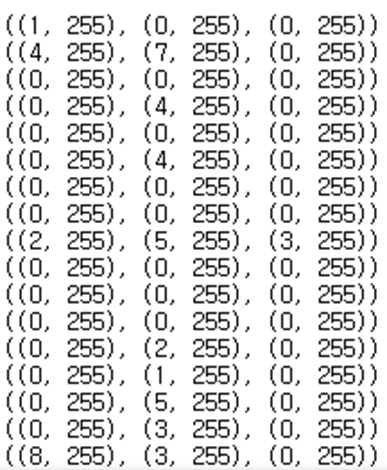

각 train 이미지의 RGB 최솟값과 최댓값

예를 들어 ((1, 255), (0, 255), (0, 255))를 보면
* r의 값 범위는 1~255
* g의 값 범위는 0~255
* b의 값 범위는 0~255로 표현됨

In [ ]:
meta_df = pd.DataFrame(data)
meta_df.head()

In [ ]:
duplicates = meta_df.groupby(by='hash')[['image_id']].count().reset_index()
duplicates = duplicates[duplicates['image_id'] > 1]
duplicates.reset_index(drop=True, inplace=True)

duplicates = duplicates.merge(meta_df[['image_id', 'hash']], on='hash')

duplicates.head(20)

* 중복되는 이미지 없음

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
train_df

In [ ]:
train_df.groupby(by='image_id')['source'].count().agg(['min', 'max', 'mean'])

bbox 최소 개수 1, 최대 개수 116, 평균 43

In [ ]:
source = train_df['source'].value_counts()
source

데이터의 출처를 시각화

In [ ]:
fig = go.Figure(data=[go.Pie(labels=source.index, values=source.values)])

fig.update_layout(title='Source distribution')
fig.show()

In [ ]:
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        ax[i].set_title(image_id)
        
def show_image_bb(image_data):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_data.iloc[0]['image_id']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i, row in image_data.iterrows():
        
        cv2.rectangle(image,
                      (int(row['x']), int(row['y'])),
                      (int(row['x']) + int(row['w']), int(row['y']) + int(row['h'])),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(image_id)

In [ ]:
show_images(train_df.sample(n=15)['image_id'].values)

In [ ]:
show_image_bb(train_df[train_df['image_id'] == '5e0747034'])

In [ ]:
show_image_bb(train_df[train_df['image_id'] == '5b13b8160'])

In [ ]:
show_image_bb(train_df[train_df['image_id'] == '1f2b1a759'])

<정리>
* extrema를 이용하여 밀의 이미지를 rgb의 최솟값과 최댓값으로 표현 가능함을 알 수 있었음
* 아래는 함수 extrema를 사용한 예시로 ((73, 255), (0, 255), (0, 255))를 rgb인 (73, 0, 0)으로 찍어보면 왼쪽 그림에서 r의 가장 어두운 부분임
* 이를 통해 r의 가장 낮은 값은 73이고 r의 범위는 73부터 255라는 것을 알게 됨

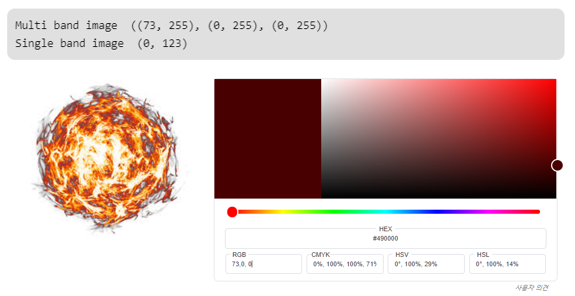